In [19]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
import optuna
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from Classes import XGBoostModel
import pickle



In [4]:
file_path = "/Users/adrianlopez/Documents/GitHub/New_CPO/daily_dbs/sharpe_tuning.csv"
df = pd.read_csv(file_path, low_memory=False)

# Preprocesamiento
df = df.drop(columns=['Unnamed: 0', 'Date', 'Portfolio_Returns'])
X = df.drop(columns=['Sortino_Ratio'])

# Normalización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
cov_matrix = np.cov(X_scaled, rowvar=False)

plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(cov_matrix, columns=X.columns, index=X.columns), cmap="coolwarm", annot=False)
plt.title("Matriz de Covarianza de las Variables")
plt.show()

KeyError: "['Sortino_Ratio'] not found in axis"

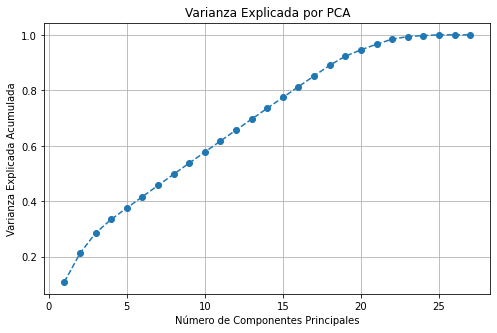

In [4]:
# Aplicar PCA sin especificar número de componentes
pca = PCA()
pca.fit(X_scaled)

# Varianza explicada acumulada
var_explicada_acumulada = np.cumsum(pca.explained_variance_ratio_)

# Graficar la varianza explicada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(var_explicada_acumulada) + 1), var_explicada_acumulada, marker='o', linestyle='--')
plt.xlabel("Número de Componentes Principales")
plt.ylabel("Varianza Explicada Acumulada")
plt.title("Varianza Explicada por PCA")
plt.grid()
plt.show()

In [5]:
# Aplicar PCA con 21 componentes principales
pca = PCA(n_components=21)
X_pca = pca.fit_transform(X_scaled)

# Imprimir varianza explicada total
total_variance = np.sum(pca.explained_variance_ratio_)
print(f"PCA aplicado: {X_pca.shape[1]} componentes principales retienen el {total_variance:.2%} de la varianza")


PCA aplicado: 21 componentes principales retienen el 96.62% de la varianza


[I 2025-03-13 10:44:33,092] A new study created in memory with name: no-name-2132d62e-8c85-4359-82f2-04ec9e952dc3
[I 2025-03-13 10:44:33,842] Trial 0 finished with value: 0.8099341755813088 and parameters: {'n_estimators': 190, 'max_depth': 3, 'learning_rate': 0.04599143576113169, 'subsample': 0.8746697772182715, 'colsample_bytree': 0.9425857524400333, 'gamma': 0.04394281198963344, 'reg_alpha': 0.36007451880419294, 'reg_lambda': 0.5204350283274566}. Best is trial 0 with value: 0.8099341755813088.
[I 2025-03-13 10:44:34,892] Trial 1 finished with value: 0.8984033719403337 and parameters: {'n_estimators': 197, 'max_depth': 4, 'learning_rate': 0.04760336713368246, 'subsample': 0.901233590777498, 'colsample_bytree': 0.8939209993855132, 'gamma': 0.042272113464528985, 'reg_alpha': 0.20831945622171008, 'reg_lambda': 0.231952954663363}. Best is trial 1 with value: 0.8984033719403337.
[I 2025-03-13 10:44:35,518] Trial 2 finished with value: 0.7527852144949438 and parameters: {'n_estimators': 17

[I 2025-03-13 10:44:56,682] Trial 21 finished with value: 0.9182416495124801 and parameters: {'n_estimators': 232, 'max_depth': 4, 'learning_rate': 0.04957553383031168, 'subsample': 0.8290040017716849, 'colsample_bytree': 0.9248451178856161, 'gamma': 0.08632629489944774, 'reg_alpha': 0.45966067652614184, 'reg_lambda': 0.461203601271939}. Best is trial 13 with value: 0.9193423428648503.
[I 2025-03-13 10:44:58,279] Trial 22 finished with value: 0.9159803359931986 and parameters: {'n_estimators': 227, 'max_depth': 4, 'learning_rate': 0.049914774315142255, 'subsample': 0.8296366756161787, 'colsample_bytree': 0.9350409504535147, 'gamma': 0.0859208419305152, 'reg_alpha': 0.4320358848093356, 'reg_lambda': 0.4857080138869738}. Best is trial 13 with value: 0.9193423428648503.
[I 2025-03-13 10:45:00,217] Trial 23 finished with value: 0.9167595623075577 and parameters: {'n_estimators': 243, 'max_depth': 4, 'learning_rate': 0.04612364242566342, 'subsample': 0.8903650410624776, 'colsample_bytree': 


 Evaluación en Test Set con PCA:
MSE: 0.1793 | R²: 0.9221


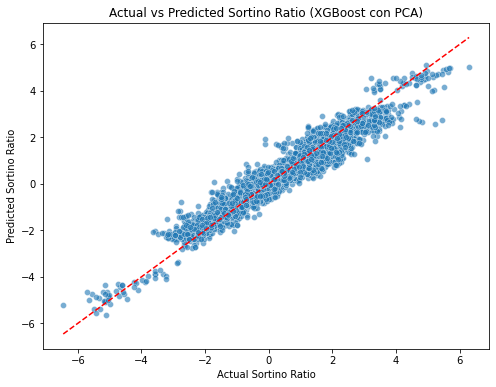

In [ ]:
file_path = "sampled_data.csv"
df = pd.read_csv(file_path, low_memory=False)


df = df.drop(columns=['Unnamed: 0', 'Date', 'Portfolio_Returns'])
X = df.drop(columns=['Sortino_Ratio'])
y = df['Sortino_Ratio']

# Normalización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA - Manteniendo 95% de varianza explicada
pca = PCA(n_components=21)
X_pca = pca.fit_transform(X_scaled)

# División en Train, Validation y Test
X_train, X_temp, y_train, y_temp = train_test_split(X_pca, y, test_size=0.3, random_state=42)
X_val, X_test, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Función objetivo para Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 150, 250),  # Reducir tamaño del modelo
        'max_depth': trial.suggest_int('max_depth', 3, 4),  # Evitar sobreajuste
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.05),  # Aprendizaje más estable
        'subsample': trial.suggest_float('subsample', 0.8, 0.95),  # Más ruido
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.85, 1.0),
        'gamma': trial.suggest_float('gamma', 0.02, 0.1),  
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 0.6),  # Aumentar regularización
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 0.6)
    }

    model = xgb.XGBRegressor(**params, objective='reg:squarederror')
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    # Penalización si R² sigue siendo mayor a 0.95
    r2_mean = scores.mean()
    if r2_mean > 0.95:
        return 0.95 - r2_mean  
    return r2_mean  


    model = xgb.XGBRegressor(**params, objective='reg:squarederror')
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    # Penalizar modelos con R² > 0.95 para evitar sobreajuste
    r2_mean = scores.mean()
    if r2_mean > 0.95:
        return 0.95 - r2_mean  # Penalización
    return r2_mean  

# Optimización con Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Entrenar el modelo con los mejores hiperparámetros
best_params = study.best_params
best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror')
best_model.fit(X_train, y_train)

# Evaluación final
preds = best_model.predict(X_test)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"\n Evaluación en Test Set con PCA:\nMSE: {mse:.4f} | R²: {r2:.4f}")

# Visualización
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': preds})
plt.figure(figsize=(8, 6))
sns.scatterplot(x=results_df["Actual"], y=results_df["Predicted"], alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Sortino Ratio")
plt.ylabel("Predicted Sortino Ratio")
plt.title("Actual vs Predicted Sortino Ratio (XGBoost con PCA)")
plt.show()

[I 2025-03-14 12:46:00,990] A new study created in memory with name: no-name-f2c96c6e-54bb-4f86-96b6-a6e694d0e273
[I 2025-03-14 12:46:01,888] Trial 0 finished with value: 0.7870136611741995 and parameters: {'n_estimators': 157, 'max_depth': 4, 'learning_rate': 0.02885257669839339, 'subsample': 0.9072420533647685, 'colsample_bytree': 0.8526291659337076, 'gamma': 0.04257080077555936, 'reg_alpha': 0.3270005128906134, 'reg_lambda': 0.5037915459549579}. Best is trial 0 with value: 0.7870136611741995.
[I 2025-03-14 12:46:02,618] Trial 1 finished with value: 0.7398010078264691 and parameters: {'n_estimators': 232, 'max_depth': 3, 'learning_rate': 0.02684946701743198, 'subsample': 0.8968274073131945, 'colsample_bytree': 0.8536104078514296, 'gamma': 0.04232023612739874, 'reg_alpha': 0.5026519127629363, 'reg_lambda': 0.5153540272865889}. Best is trial 0 with value: 0.7870136611741995.
[I 2025-03-14 12:46:03,679] Trial 2 finished with value: 0.8819326707467023 and parameters: {'n_estimators': 202

[I 2025-03-14 12:46:23,742] Trial 21 finished with value: 0.9206860993298289 and parameters: {'n_estimators': 246, 'max_depth': 4, 'learning_rate': 0.04955810277586582, 'subsample': 0.8576835168289797, 'colsample_bytree': 0.9080093208582019, 'gamma': 0.08416996426119944, 'reg_alpha': 0.14487756333866733, 'reg_lambda': 0.29179155515683886}. Best is trial 12 with value: 0.9236453219437009.
[I 2025-03-14 12:46:25,270] Trial 22 finished with value: 0.918978146217967 and parameters: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.047157355574611454, 'subsample': 0.8775605415198452, 'colsample_bytree': 0.9095117963648736, 'gamma': 0.07143116785943039, 'reg_alpha': 0.10021441597278538, 'reg_lambda': 0.2658765430725418}. Best is trial 12 with value: 0.9236453219437009.
[I 2025-03-14 12:46:26,731] Trial 23 finished with value: 0.91945015665782 and parameters: {'n_estimators': 238, 'max_depth': 4, 'learning_rate': 0.04979579621815958, 'subsample': 0.8556485798717663, 'colsample_bytree':


 Evaluación en Test Set con PCA:
MSE: 0.1791 | R²: 0.9222


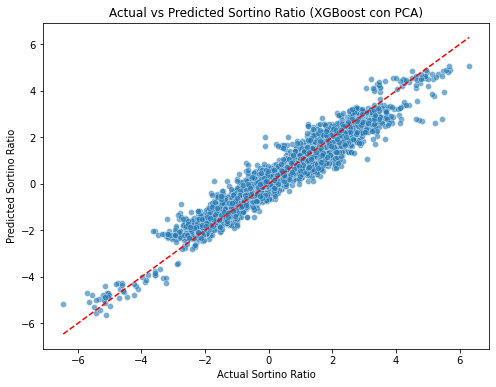

In [6]:
file_path = "sampled_data.csv"
df = pd.read_csv(file_path, low_memory=False)


df = df.drop(columns=['Unnamed: 0', 'Date', 'Portfolio_Returns'])
X = df.drop(columns=['Sortino_Ratio'])
y = df['Sortino_Ratio']

# Normalización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA - Manteniendo 95% de varianza explicada
pca = PCA(n_components=21)
X_pca = pca.fit_transform(X_scaled)

# División en Train, Validation y Test
X_train, X_temp, y_train, y_temp = train_test_split(X_pca, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Función objetivo para Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 150, 250),  # Reducir tamaño del modelo
        'max_depth': trial.suggest_int('max_depth', 3, 4),  # Evitar sobreajuste
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.05),  # Aprendizaje más estable
        'subsample': trial.suggest_float('subsample', 0.8, 0.95),  # Más ruido
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.85, 1.0),
        'gamma': trial.suggest_float('gamma', 0.02, 0.1),  
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 0.6),  # Aumentar regularización
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 0.6)
    }

    model = xgb.XGBRegressor(**params, objective='reg:squarederror')
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    # Penalización si R² sigue siendo mayor a 0.95
    r2_mean = scores.mean()
    if r2_mean > 0.95:
        return 0.95 - r2_mean  
    return r2_mean  


    model = xgb.XGBRegressor(**params, objective='reg:squarederror')
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    # Penalizar modelos con R² > 0.95 para evitar sobreajuste
    r2_mean = scores.mean()
    if r2_mean > 0.95:
        return 0.95 - r2_mean  # Penalización
    return r2_mean  

# Optimización con Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Entrenar el modelo con los mejores hiperparámetros
best_params = study.best_params
best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror')
best_model.fit(X_train, y_train)

# Evaluación final
preds = best_model.predict(X_test)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"\n Evaluación en Test Set con PCA:\nMSE: {mse:.4f} | R²: {r2:.4f}")

# Visualización
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': preds})
plt.figure(figsize=(8, 6))
sns.scatterplot(x=results_df["Actual"], y=results_df["Predicted"], alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Sortino Ratio")
plt.ylabel("Predicted Sortino Ratio")
plt.title("Actual vs Predicted Sortino Ratio (XGBoost con PCA)")
plt.show()

In [7]:
print("✅ Mejores hiperparámetros encontrados:")
print(study.best_params)


✅ Mejores hiperparámetros encontrados:
{'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.049221833118794175, 'subsample': 0.8645617337327893, 'colsample_bytree': 0.9129687689033119, 'gamma': 0.08648654064554967, 'reg_alpha': 0.1051912791786866, 'reg_lambda': 0.280839131994105}


In [ ]:

# Guardar el modelo entrenado
with open("xgboost_pca_model.pkl", "wb") as f:
    pickle.dump(best_model, f)



In [9]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 0.2),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }
    model = XGBoostModel(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return r2_score(y_val, preds)

# Split your data into train/validation for tuning
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best params:", study.best_params)

[I 2025-06-23 08:14:03,420] A new study created in memory with name: no-name-b334bf12-b272-4ce4-b5d6-d05e5ec0585d
[I 2025-06-23 08:14:05,298] Trial 0 finished with value: 0.2604948909069632 and parameters: {'n_estimators': 270, 'max_depth': 4, 'learning_rate': 0.0369806385412485, 'subsample': 0.9212975508577699, 'colsample_bytree': 0.9979195722612588, 'gamma': 0.07118406803863027, 'reg_alpha': 0.5067734338946108, 'reg_lambda': 0.5955352786692419}. Best is trial 0 with value: 0.2604948909069632.
[I 2025-06-23 08:14:05,298] Trial 0 finished with value: 0.2604948909069632 and parameters: {'n_estimators': 270, 'max_depth': 4, 'learning_rate': 0.0369806385412485, 'subsample': 0.9212975508577699, 'colsample_bytree': 0.9979195722612588, 'gamma': 0.07118406803863027, 'reg_alpha': 0.5067734338946108, 'reg_lambda': 0.5955352786692419}. Best is trial 0 with value: 0.2604948909069632.


XGBoost model trained.


[I 2025-06-23 08:14:06,398] Trial 1 finished with value: 0.10229794040122886 and parameters: {'n_estimators': 145, 'max_depth': 3, 'learning_rate': 0.041677924945243194, 'subsample': 0.8530206407075245, 'colsample_bytree': 0.7860565320666745, 'gamma': 0.01222590249963136, 'reg_alpha': 0.4790720800563535, 'reg_lambda': 0.44304388199081357}. Best is trial 0 with value: 0.2604948909069632.


XGBoost model trained.


[I 2025-06-23 08:14:07,555] Trial 2 finished with value: 0.13361501118354802 and parameters: {'n_estimators': 117, 'max_depth': 5, 'learning_rate': 0.020790793834299978, 'subsample': 0.7880664006938352, 'colsample_bytree': 0.8734207560188614, 'gamma': 0.060568027341123834, 'reg_alpha': 0.2954785078951365, 'reg_lambda': 0.2762503000833004}. Best is trial 0 with value: 0.2604948909069632.


XGBoost model trained.


[I 2025-06-23 08:14:08,641] Trial 3 finished with value: 0.23287048794347254 and parameters: {'n_estimators': 222, 'max_depth': 3, 'learning_rate': 0.08144814403508169, 'subsample': 0.9298626003088744, 'colsample_bytree': 0.8375343504674038, 'gamma': 0.17453692342535382, 'reg_alpha': 0.021113337720395586, 'reg_lambda': 0.5676774468642601}. Best is trial 0 with value: 0.2604948909069632.


XGBoost model trained.


[I 2025-06-23 08:14:10,302] Trial 4 finished with value: 0.3538803610837823 and parameters: {'n_estimators': 162, 'max_depth': 6, 'learning_rate': 0.034576386255642265, 'subsample': 0.8429093456680938, 'colsample_bytree': 0.8888294872625347, 'gamma': 0.06223677201722482, 'reg_alpha': 0.34798991275055147, 'reg_lambda': 0.6041173813458477}. Best is trial 4 with value: 0.3538803610837823.


XGBoost model trained.


[I 2025-06-23 08:14:11,842] Trial 5 finished with value: 0.31711223101628017 and parameters: {'n_estimators': 251, 'max_depth': 4, 'learning_rate': 0.05502178269068096, 'subsample': 0.9559529518028892, 'colsample_bytree': 0.8513304553700088, 'gamma': 0.029351485037245918, 'reg_alpha': 0.5424012802399673, 'reg_lambda': 0.3339008435852556}. Best is trial 4 with value: 0.3538803610837823.


XGBoost model trained.


[I 2025-06-23 08:14:13,486] Trial 6 finished with value: 0.36070284600691127 and parameters: {'n_estimators': 265, 'max_depth': 4, 'learning_rate': 0.06154706930638446, 'subsample': 0.9896748590104785, 'colsample_bytree': 0.9616024603425533, 'gamma': 0.13149697759924148, 'reg_alpha': 0.6376960853099015, 'reg_lambda': 0.336960274680179}. Best is trial 6 with value: 0.36070284600691127.


XGBoost model trained.


[I 2025-06-23 08:14:14,752] Trial 7 finished with value: 0.18683298070422072 and parameters: {'n_estimators': 126, 'max_depth': 6, 'learning_rate': 0.020038485176443833, 'subsample': 0.9691392714512415, 'colsample_bytree': 0.7277621416284584, 'gamma': 0.12274605860898302, 'reg_alpha': 0.6365029852096484, 'reg_lambda': 0.203166962786282}. Best is trial 6 with value: 0.36070284600691127.


XGBoost model trained.


[I 2025-06-23 08:14:16,006] Trial 8 finished with value: 0.1498694576519949 and parameters: {'n_estimators': 145, 'max_depth': 5, 'learning_rate': 0.020526272003137697, 'subsample': 0.8827806593340819, 'colsample_bytree': 0.7463453077743474, 'gamma': 0.11812729875760751, 'reg_alpha': 0.8249333492995827, 'reg_lambda': 0.9166144036904171}. Best is trial 6 with value: 0.36070284600691127.


XGBoost model trained.


[I 2025-06-23 08:14:17,089] Trial 9 finished with value: 0.4118342769285339 and parameters: {'n_estimators': 163, 'max_depth': 5, 'learning_rate': 0.07296901033860945, 'subsample': 0.8671558235234995, 'colsample_bytree': 0.703694157302535, 'gamma': 0.11130967709030466, 'reg_alpha': 0.8166385041285876, 'reg_lambda': 0.7015612241090433}. Best is trial 9 with value: 0.4118342769285339.


XGBoost model trained.


[I 2025-06-23 08:14:18,660] Trial 10 finished with value: 0.545100436221065 and parameters: {'n_estimators': 191, 'max_depth': 5, 'learning_rate': 0.08991021128619137, 'subsample': 0.711128915132425, 'colsample_bytree': 0.7114423021918799, 'gamma': 0.19320123471650874, 'reg_alpha': 0.992535651285279, 'reg_lambda': 0.021725554010588066}. Best is trial 10 with value: 0.545100436221065.


XGBoost model trained.


[I 2025-06-23 08:14:20,157] Trial 11 finished with value: 0.5803693613654001 and parameters: {'n_estimators': 191, 'max_depth': 5, 'learning_rate': 0.09981192913404222, 'subsample': 0.7151583444032759, 'colsample_bytree': 0.7009000073181115, 'gamma': 0.18732066216136728, 'reg_alpha': 0.9618740655999931, 'reg_lambda': 0.06679770158465037}. Best is trial 11 with value: 0.5803693613654001.


XGBoost model trained.


[I 2025-06-23 08:14:21,748] Trial 12 finished with value: 0.5825210442777627 and parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.097209860287509, 'subsample': 0.7006235974136568, 'colsample_bytree': 0.7772044164209074, 'gamma': 0.19879535096221293, 'reg_alpha': 0.99237792214673, 'reg_lambda': 0.012827067109832148}. Best is trial 12 with value: 0.5825210442777627.


XGBoost model trained.


[I 2025-06-23 08:14:25,359] Trial 13 finished with value: 0.7291819225465195 and parameters: {'n_estimators': 206, 'max_depth': 6, 'learning_rate': 0.0945639011343021, 'subsample': 0.7073523192657364, 'colsample_bytree': 0.778982510180791, 'gamma': 0.16474726742688975, 'reg_alpha': 0.8990881906600514, 'reg_lambda': 0.006306314755122708}. Best is trial 13 with value: 0.7291819225465195.


XGBoost model trained.


[I 2025-06-23 08:14:29,790] Trial 14 finished with value: 0.8351135088735284 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.09437520854025253, 'subsample': 0.760134409258957, 'colsample_bytree': 0.7844564369302189, 'gamma': 0.15628002532567653, 'reg_alpha': 0.8255009142363116, 'reg_lambda': 0.17066679740109292}. Best is trial 14 with value: 0.8351135088735284.


XGBoost model trained.


[I 2025-06-23 08:14:33,119] Trial 15 finished with value: 0.7546393461996397 and parameters: {'n_estimators': 292, 'max_depth': 6, 'learning_rate': 0.0718919115494566, 'subsample': 0.7679690901057777, 'colsample_bytree': 0.8071223140581091, 'gamma': 0.1576892681902104, 'reg_alpha': 0.8158119585495283, 'reg_lambda': 0.16833937394921328}. Best is trial 14 with value: 0.8351135088735284.


XGBoost model trained.


[I 2025-06-23 08:14:35,573] Trial 16 finished with value: 0.7627783573667686 and parameters: {'n_estimators': 293, 'max_depth': 6, 'learning_rate': 0.07434950076903646, 'subsample': 0.7653501461131381, 'colsample_bytree': 0.8160019788569285, 'gamma': 0.14964491709402944, 'reg_alpha': 0.75008716845679, 'reg_lambda': 0.17489899425928435}. Best is trial 14 with value: 0.8351135088735284.


XGBoost model trained.


[I 2025-06-23 08:14:38,934] Trial 17 finished with value: 0.792186380317796 and parameters: {'n_estimators': 295, 'max_depth': 6, 'learning_rate': 0.08234716651502905, 'subsample': 0.7760024823069104, 'colsample_bytree': 0.8959768994997229, 'gamma': 0.14543350971572325, 'reg_alpha': 0.7228522510218227, 'reg_lambda': 0.4288483774305568}. Best is trial 14 with value: 0.8351135088735284.


XGBoost model trained.


[I 2025-06-23 08:14:41,821] Trial 18 finished with value: 0.7541740169888804 and parameters: {'n_estimators': 244, 'max_depth': 6, 'learning_rate': 0.08499592621029664, 'subsample': 0.8083912279614085, 'colsample_bytree': 0.9226021551949636, 'gamma': 0.09030137290807505, 'reg_alpha': 0.6898343944038781, 'reg_lambda': 0.4639045757448736}. Best is trial 14 with value: 0.8351135088735284.


XGBoost model trained.


[I 2025-06-23 08:14:45,086] Trial 19 finished with value: 0.8022454148738614 and parameters: {'n_estimators': 299, 'max_depth': 6, 'learning_rate': 0.08445925534753877, 'subsample': 0.7469234596769981, 'colsample_bytree': 0.926751076001819, 'gamma': 0.1360271711672036, 'reg_alpha': 0.33287983272164945, 'reg_lambda': 0.7931431650542369}. Best is trial 14 with value: 0.8351135088735284.


XGBoost model trained.


[I 2025-06-23 08:14:48,276] Trial 20 finished with value: 0.6903826007848632 and parameters: {'n_estimators': 269, 'max_depth': 6, 'learning_rate': 0.06316628327060576, 'subsample': 0.7361358505073665, 'colsample_bytree': 0.9244332926330147, 'gamma': 0.09303740048298263, 'reg_alpha': 0.15686047576517453, 'reg_lambda': 0.9391295810500551}. Best is trial 14 with value: 0.8351135088735284.


XGBoost model trained.


[I 2025-06-23 08:14:52,411] Trial 21 finished with value: 0.7901706872451245 and parameters: {'n_estimators': 297, 'max_depth': 6, 'learning_rate': 0.08166549924806889, 'subsample': 0.8150133814673082, 'colsample_bytree': 0.9083786488991451, 'gamma': 0.14060805386712583, 'reg_alpha': 0.39134134733977066, 'reg_lambda': 0.8051820290154649}. Best is trial 14 with value: 0.8351135088735284.


XGBoost model trained.


[I 2025-06-23 08:14:55,852] Trial 22 finished with value: 0.8119685349614327 and parameters: {'n_estimators': 285, 'max_depth': 6, 'learning_rate': 0.09225238641625229, 'subsample': 0.7536696311256332, 'colsample_bytree': 0.9607816798699373, 'gamma': 0.14271091856653098, 'reg_alpha': 0.22759491216162675, 'reg_lambda': 0.7650830027953709}. Best is trial 14 with value: 0.8351135088735284.


XGBoost model trained.


[I 2025-06-23 08:14:59,329] Trial 23 finished with value: 0.7981933514095596 and parameters: {'n_estimators': 278, 'max_depth': 6, 'learning_rate': 0.08965123946200944, 'subsample': 0.7458178919830418, 'colsample_bytree': 0.956484687000253, 'gamma': 0.17825105977899303, 'reg_alpha': 0.18239547540683065, 'reg_lambda': 0.7959851670483367}. Best is trial 14 with value: 0.8351135088735284.


XGBoost model trained.


[I 2025-06-23 08:15:01,656] Trial 24 finished with value: 0.6141141177664668 and parameters: {'n_estimators': 235, 'max_depth': 5, 'learning_rate': 0.09074731901980047, 'subsample': 0.7348808795509645, 'colsample_bytree': 0.9959875403228076, 'gamma': 0.1622332690243039, 'reg_alpha': 0.2274220127367248, 'reg_lambda': 0.7268332308287839}. Best is trial 14 with value: 0.8351135088735284.


XGBoost model trained.


[I 2025-06-23 08:15:05,262] Trial 25 finished with value: 0.7252519449611537 and parameters: {'n_estimators': 280, 'max_depth': 6, 'learning_rate': 0.06767493911988985, 'subsample': 0.7996946584610821, 'colsample_bytree': 0.9610643531531261, 'gamma': 0.10624867470143484, 'reg_alpha': 0.06357907710943667, 'reg_lambda': 0.9932190245174318}. Best is trial 14 with value: 0.8351135088735284.


XGBoost model trained.


[I 2025-06-23 08:15:07,961] Trial 26 finished with value: 0.5980099497424518 and parameters: {'n_estimators': 259, 'max_depth': 5, 'learning_rate': 0.07747657076336589, 'subsample': 0.7513558927549516, 'colsample_bytree': 0.9381432149991775, 'gamma': 0.1296688625745384, 'reg_alpha': 0.40348267498248463, 'reg_lambda': 0.8311243170355997}. Best is trial 14 with value: 0.8351135088735284.


XGBoost model trained.


[I 2025-06-23 08:15:11,324] Trial 27 finished with value: 0.799069763986493 and parameters: {'n_estimators': 281, 'max_depth': 6, 'learning_rate': 0.09008687775434707, 'subsample': 0.8215525293666633, 'colsample_bytree': 0.8610533348611751, 'gamma': 0.13918009237054996, 'reg_alpha': 0.28074294009479817, 'reg_lambda': 0.6842050750993163}. Best is trial 14 with value: 0.8351135088735284.


XGBoost model trained.


[I 2025-06-23 08:15:13,222] Trial 28 finished with value: 0.2697531061011863 and parameters: {'n_estimators': 230, 'max_depth': 4, 'learning_rate': 0.04637052185139652, 'subsample': 0.7838561672575339, 'colsample_bytree': 0.9776427684828952, 'gamma': 0.178269313398917, 'reg_alpha': 0.10414572465508551, 'reg_lambda': 0.5326020840667068}. Best is trial 14 with value: 0.8351135088735284.


XGBoost model trained.


[I 2025-06-23 08:15:16,093] Trial 29 finished with value: 0.22184899130042057 and parameters: {'n_estimators': 256, 'max_depth': 6, 'learning_rate': 0.011366408423831638, 'subsample': 0.8345980636060826, 'colsample_bytree': 0.9992606618073566, 'gamma': 0.08374241275550734, 'reg_alpha': 0.5717021123723708, 'reg_lambda': 0.6311886381069941}. Best is trial 14 with value: 0.8351135088735284.


XGBoost model trained.
Best params: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.09437520854025253, 'subsample': 0.760134409258957, 'colsample_bytree': 0.7844564369302189, 'gamma': 0.15628002532567653, 'reg_alpha': 0.8255009142363116, 'reg_lambda': 0.17066679740109292}


XGBoost model trained.
Evaluation -- MSE: 7.1670, R2: 0.8321


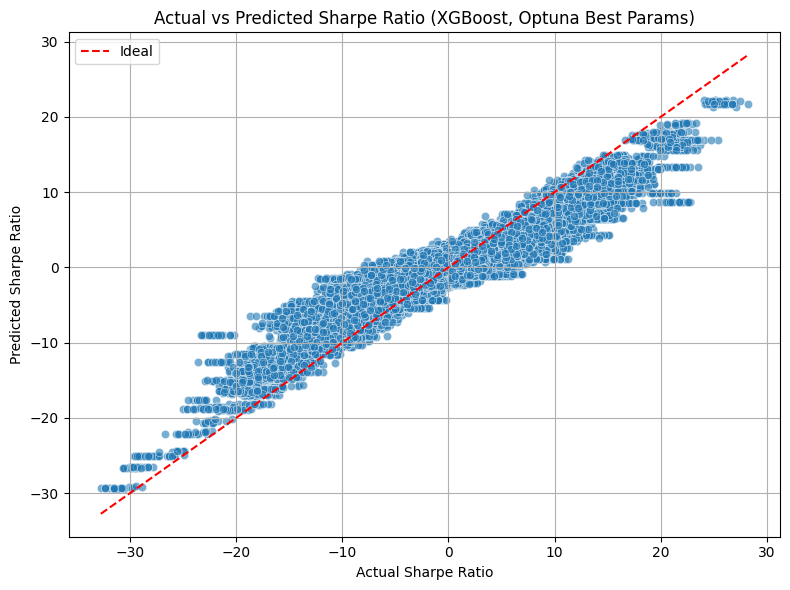

In [7]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
from Classes import XGBoostModel
import pickle



df = pd.read_csv(os.path.join(project_root,"daily_dbs", "sharpe_daily_LowCap.csv"))
df = df.drop(columns=['Unnamed: 0', 'Date', 'Portfolio_Returns'])
X = df.drop(columns=['Sharpe_Ratio'])
y = df['Sharpe_Ratio']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.2, random_state=10)

best_params = {
    'n_estimators': 300,
    'max_depth': 6,
    'learning_rate': 0.09437520854025253,
    'subsample': 0.760134409258957,
    'colsample_bytree': 0.7844564369302189,
    'gamma': 0.15628002532567653,
    'reg_alpha': 0.8255009142363116,
    'reg_lambda': 0.17066679740109292,
    'objective': 'reg:squarederror'
}
model = XGBoostModel(**best_params)
model.fit(X_train, y_train)

preds = model.predict(X_test)

model.evaluate(X_test, y_test)

results_df = pd.DataFrame({'Actual': y_test, 'Predicted': preds})
plt.figure(figsize=(8, 6))
sns.scatterplot(x=results_df["Actual"], y=results_df["Predicted"], alpha=0.6)
plt.plot([
    results_df["Actual"].min(), results_df["Actual"].max()
], [
    results_df["Actual"].min(), results_df["Actual"].max()
], 'r--', label='Ideal')
plt.xlabel("Actual Sharpe Ratio")
plt.ylabel("Predicted Sharpe Ratio")
plt.title("Actual vs Predicted Sharpe Ratio (XGBoost, Optuna Best Params)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

output_path = os.path.join(project_root, "trained_models")
os.makedirs(output_path, exist_ok=True)

with open(os.path.join(output_path, "xgboost_model_LowCap.pkl"), "wb") as f:
    pickle.dump(model, f)